## make A2C fluid
# A2C流体版
# 学習

In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as offline
import plotly.graph_objs as go


from collections import deque, Counter

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from gym import spaces
from gym.spaces.box import Box


import os
import subprocess
import PyFoam
import PyFoam.FoamInformation
from PyFoam.RunDictionary.SolutionDirectory import SolutionDirectory
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
from PyFoam.Basics.DataStructures import Vector
from PyFoam.Execution.BasicRunner import BasicRunner
from PyFoam.Basics.TemplateFile import TemplateFile
import shlex,sys,json
import re
from pathlib import Path

from copy import copy
import random

In [2]:
# set directory
# 試す用
CASE = SolutionDirectory("./Case/case0")

In [3]:
## 実行環境の設定

class Aircond:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=100,end=3000,xCells=40,
                         insert_list = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5,0.7])
        self.action_DIRECTION = np.array([0, -1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([17+273.15,20+273.15,23+273.15, 26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(64,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        #self.constant_file = []
        #for y in os.listdir(self.constant):
        #    if os.path.isfile(self.constant + y):
        #        self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得
        各U1, U2, Tがすべて一列で並んだ状態を返す'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir,celsius=True):
        '''observationを２次元で取得。
        障害物があるところは全て値を0で埋める。
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        # セルシウス℃に直す
        if celsius:
            T_value = self.Celsius_(T_value)
            T_value = T_value.astype(np.float64)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        """PMVとPPDを計算
        デフォルト値。TA,VA,TR,RHまでは入力を推奨
        TA = 20  #  温度[℃]
        VA = 0.3  # 流速[m/s]
        TR = 20  # MRT[℃]
        RH = 50  # 相対湿度[%]
        AL = 1  # 活動量[met]
        CLO = 1 # 着衣量[clo]
        
        """
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        # 初期化
        PMV = 0
        PPD = 0
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                elif T_Parsed['boundaryField'][boundary]['type']=='fixedGradient':
                        T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                elif T_Parsed['boundaryField'][boundary]['type']=='fixedGradient':
                        T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''np.arrayの配列をセルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed,RH=50,AL=1,CLO=1):
        '''PMVを一つのtime_stepで全点計算
        TU_Parsed : TとUのParsedParameterFileをリストにしたもの
        全ての点のPMVとPPVの値を返す
        time=0でも、すべてのセルの値を返す。'''
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius_(T)
            MRTc = self.Celsius_(MRT)
            pmv,ppd = self.calc_PMV(TA=Tc,VA=Us,TR=MRTc,RH=RH,AL=AL,CLO=CLO)
            PMV_list = np.tile(pmv, self.nCells)
            PPD_list = np.tile(ppd, self.nCells)
        else:   
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = list(self.Celsius_(T))
            MRTc = self.Celsius_(MRT)
            
            length = len(T)
            # ループを早くするため、外に出す。
            PMV_list = []
            PPD_list = []
            PMV_list_append = PMV_list.append
            PPD_list_append = PPD_list.append
            for i in range(length):
                pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=RH,AL=AL,CLO=CLO)
                PMV_list_append(pmv)
                PPD_list_append(ppd)
            PMV_list = np.array(PMV_list)
            PPD_list = np.array(PPD_list)
        return PMV_list,PPD_list
    
    def calc_PMV_error(self, TU_Parsed,RH=50,AL=1,CLO=1):
        """PMVの全点の2条誤差の合計を計算
        入力はcalc_PMV_allと同じ。返すものだけが違う。
        PMVは、0との2乗誤差、PPDは0との、根平均2乗誤差を返す。
        """
        PMV, PPD = self.calc_PMV_all(TU_Parsed, RH=RH,AL=AL,CLO=CLO)
        PMV_mae = ((PMV - 0)**2).mean()
        PPD_rmse = np.sqrt( ((PPD - 0)**2).mean())
        return PMV_mae, PPD_rmse
    

    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def change_write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        self.controlDict.writeFile()
        
        
    def reset(self, initial_T="random"):
        '''環境のリセット
        initial_Tは℃
        '''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム
        T_the_first = ParsedParameterFile(self.CASE.initialDir() + '/T')
        if initial_T=="random":
            # random parameter from 26 to 35
            initial_T_condition = np.random.uniform(26+273.15,35+273.15)
        else:
            initial_T_condition = initial_T + 273.15
        T_the_first['internalField'].setUniform(initial_T_condition)
        T_the_first.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        
        # doneとrunOKをリセット
        self.done = False
        self.runOK = True
        self.reward = 0
        
        return self.observation
    def random_step(self,max_execution=3):
        """ランダムに0~max_executionステップ進める"""
        action_shape = self.action_space.shape[0]
        random_action = []

        for j in range(random.randint(0,max_execution)):
            random_action.append(random.randint(0, action_shape-1))
        for act in random_action:
            self.step(act)    
        return self.observation, self.reward, self.done, self.runOK
    
    def step(self, action, reward='PMV', sqb=0.1):
        '''ステップを進める
        報酬はPMV等から選択
        '''
    
        if self.done or not self.runOK:
            self.reset()
            # sqb%でrandom_stepを実行
            if random.random()<sqb:
                self.random_step()
                self.reward = 0
            print("reset")
            # rewardと、observationは1ステップ前の値をそのまま使う。
        else:
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            self.runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride # CASE内の時間を進める
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
            # 報酬の計算。make_observationでは、0を補完していれているため、用いない。
            T_new = ParsedParameterFile(self.CASE.latestDir() + '/T')
            U_new = ParsedParameterFile(self.CASE.latestDir() + '/U')
            TU_Parsed = [T_new,U_new]
            PMV_mae, PPD_rmse = self.calc_PMV_error(TU_Parsed, RH=50,AL=1,CLO=1)
            # 報酬は、ズレ分をマイナス、ちかづいたら、プラスにする。
            self.reward = -PMV_mae
            
            # doneの判定
            if self.present_time >= self.end:
                self.done = True
            else:
                self.done = False
            
        
        return self.observation, self.reward, self.done, self.runOK
        

In [4]:
def read_polyMesh(name):
    with open (self.CASE.name + "/constant/polyMesh/{}".format(name),"r") as f:
        lines = f.readlines()  # 読み込み
        # 改行コードを取り除く
        meshinfo = []
        meshinfo_append = meshinfo.append
        for line in lines:
            line_ = line.rstrip('\n')
            # "" のような空の文字列を取り除いて、始まる数を揃える
            if len(line_)!=0:
                meshinfo_append(line_)
        # header部分の'}'の部分を特定する
        for i,mesinf in enumerate(meshinfo):
            if mesinf=='}':
                break
        meshinfo_num = meshinfo[i+2]  # i+2番目に最初の数の情報
        meshinfo_ = meshinfo[i+4:-2]  # i+4番目-2までが中身
    return meshinfo_num, meshinfo_

In [17]:
Envs = makecase(2)

In [18]:
resets(Envs)

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [ ]:
self = Aircond(CASE)

In [ ]:
self.reset()

In [ ]:
self.step(1)

In [18]:
class Sample:
    
    def __init__(self, CASE):
        self.CASE = CASE
        # メッシュの情報を全て読み込む
        self.read_all()
        
        self.points = self.pointslist_to_array(self.points_)  # 各点の座標。順番に番号が0から振られている。
        self.faces = self.faceslist_to_array(self.faces_)  # 各面がどの点から構成されているか、pointsの番号と対応
        self.owner = self.strlist_to_array(self.owner_)  # 各面がどのセルに属しているか。
        self.neighbour = self.strlist_to_array(self.neighbour_)  # 各面がどのセルと隣り合っているか。

    def read_polyMesh(self,name):
        """constantのployMesh中のメッシュ情報のファイルを読み込む関数。
        一行ずつ読み込んで、ヘッダーと空白を消して、読み込むという強引なことをしているので、
        情報が縦にきじゅつされていないは想定していない。
        """
        with open (self.CASE.name + "/constant/polyMesh/{}".format(name),"r") as f:
            lines = f.readlines()  # 読み込み
            # 改行コードを取り除く
            meshinfo = []
            meshinfo_append = meshinfo.append
            for line in lines:
                line_ = line.rstrip('\n')
                # "" のような空の文字列を取り除いて、始まる数を揃える
                if len(line_)!=0:
                    meshinfo_append(line_)
            # header部分の'}'の部分を特定する
            for i,mesinf in enumerate(meshinfo):
                if mesinf=='}':
                    break
            meshinfo_num = meshinfo[i+2]  # i+2番目に最初の数の情報
            meshinfo_ = meshinfo[i+4:-2]  # i+4番目-2までが中身
        return meshinfo_num, meshinfo_

    def read_all(self):
        """constantのpolymeshの中の情報をクラス内のインスタンスに読み込む。
        self.faces_num等に個数、self.faces_等にリスト化された情報が読み込まれる。
        """
        # boundary_num, boundary = read_polyMesh("bouundary")
        polyMeshs = ["boundary", "cellZones", "faces", "neighbour", "owner", "points", "pointZones"]
        for poly in polyMeshs:
            # 例 : self.faces_num, self.faces_ = self.read_polyMesh(faces)
            exec("self."+poly+"_num, self."+poly+"_"+"=" + "self.read_polyMesh(poly)")
            
    def pointvector_split(self, str_):
        """
        '(0 0 0)'のようなベクトルをflattenして、floatにする。
        pointsのmap用
        """
        str_split = str_.strip("()").split(" ")
        float_split = [float(x) for x in str_split]
        return float_split
    
    def pointslist_to_array(self, meshinfo):
        """
        ['(0 0 0)','(0 0 1)']とかで構成されたリストをnumpyにする。
        points用。pointvector_splitを使用する。
        """
        return np.array(list(map(self.pointvector_split, meshinfo)))
    
    def strlist_to_array(self,meshinfo):
        """
        ['(0 0 0)','(0 0 1)']とかで構成されたリストをnumpyにする。
        owner用
        """
        return np.array(list(map(int, meshinfo)))
    
    def facevector_split(self,face):
        """
        '4(1 37 554 518)'のようなベクトルをsplitして、floatにする。
        4 1 37 554 518のようなarrayに
        neighbourのmap用。
        """
        face_ = face.split("(")  # 4と()部分を分ける
        face_num = face_[0]
        face_body = face_[1]
        face_split = face_body.strip("()").split(" ")
        float_split = [int(face_num)] + [int(x) for x in face_split]
        return np.array(float_split)
    
    def faceslist_to_array(self,faces):
        """
        ['4(1 37 554 518)','4(36 553 554 37)']とかで構成されたリストをnumpyにする。
        neighbour用。
        """
        faces_ = list(map(self.facevector_split, faces))
        #l = max(map(len,faces_))
        #faces_after = list(map(lambda x: x+[None]*(l-len(x)), faces_))
        return np.array(faces_)
    
    def make_mesh_points(self, points='self', faces='self', owner='self', neighbour='self'):
        
        # セルのnumberと6つのpointsからなる座標を対応付ける。
        if points=='self':
            points = self.points
        if faces=='self':
            faces = self.faces
        if owner=='self':
            owner = self.owner
        if neighbour=='self':
            neighbour = self.neighbour
            
        # faceとpointsを対応付ける。
        # faceの情報をpointsに直す
        faces_points = []
        faces_points_append = faces_points.append
        len_faces = faces.shape[0]  # facesの数
        n_face = faces[:,0]  # 1faceの中でのpointsの数
        for i in range(len_faces):
            face_point = []
            face_point_append = face_point.append
            for j in range(n_face[i]):
                coordinate = points[faces[i,j+1],:]
                face_point_append(coordinate)
            faces_points_append(face_point)
        faces_points = np.array(faces_points)


        # セルとpointsを対応付ける
        n_cells = max(owner)+1
        cell_faces_points = [[] for i in range(n_cells)]

        # まず、各faceがどのセルに属しているかを算出し、該当するセルにpointsを追加する
        len_owner = owner.shape[0]
        for i in range(len(owner)):
            face_point = faces_points[i]
            cell_faces_points[owner[i]].append(face_point)

        # neighbourの情報から、各faceがどのセルに属するかを算出し、該当するセルにpointsを追加する
        len_neighbour = neighbour.shape[0]
        for i in range(len_neighbour):
            # 面の向きをそろえるために、neighbourで追加するセルは、逆向きにする
            face_point = faces_points[i].copy()
            tmp = face_point[1].copy()
            face_point[1] = face_point[3]
            face_point[3] = tmp
            cell_faces_points[neighbour[i]].append(face_point)

        cell_faces_points = np.array(cell_faces_points)


        # セルのfacesから被りpointsをなくして、構成される点にする。
        cell_points = []
        cell_points_append = cell_points.append
        for cfp in cell_faces_points:
            points_flatten = cfp.reshape(-1,cfp.shape[-1])
            points_unique = pd.DataFrame(points_flatten).drop_duplicates().values
            cell_points_append(points_unique)
        cell_points = np.array(cell_points)

        # セルのポイントを中心にする
        cell_points_center = []
        cell_points_center_append = cell_points_center.append

        for cell in cell_points:
            cell_center = np.mean(cell, axis=0)
            cell_points_center_append(cell_center)
        cell_points_center = np.array(cell_points_center)
        
        # 定義域
        # pointsの定義域を算出する
        # [8.0, 2.4 , 0.1]など
        cell_points_flatten = cell_points.reshape(-1,3)
        min_cell_point = np.min(cell_points_flatten, axis=0)
        max_cell_point = np.max(cell_points_flatten, axis=0)
        domain = np.array([min_cell_point, max_cell_point])
        
        self.faces_points = faces_points
        self.cell_faces_points = cell_faces_points
        self.cell_points = cell_points
        self.cell_points_center = cell_points_center
        self.domain = domain
        
        return self.faces_points, self.cell_faces_points, self.cell_points, self.cell_points_center, self.domain
    
    def make_insert_list(self, pick_width=[0.2,0.2,0],xyz_cell='calc'):
        """面の内向き法線ベクトルを求めて、点がていぎされているかどうかを調べる"""
        faces_points,cell_faces_points,cell_points,cell_points_center, domain = self.make_mesh_points()
        if xyz_cell=='calc':
            x = np.unique(self.cell_points_center[:,0].round(3)).shape[0]
            y = np.unique(self.cell_points_center[:,1].round(3)).shape[0]
            z = np.unique(cell_points_center[:,2].round(3)).shape[0]
            xyz_cell = np.array([x,y,z])
        else:
            xyz_cell = np.array(xyz_cell)
        
        pick_width = np.array(pick_width)
        
        
        
        # 値を等間隔で取り出す。
        #pick_width = np.array([0.2,0.2,0])  # 取り出す幅
        #xyz_cell = np.array([40,12,1])  # 何個の値にするか

        # pointsの最小値と最大値domainから、セルの定義域を算出。
        cell_min = domain[0,:]+pick_width/2
        cell_max = domain[1,:]-pick_width/2

        # 2次元の場合、3次元成分を0.05にしておく
        if pick_width[2]==0.0 and cell_min[2]==0.0 and cell_max[2]==0.1:
            cell_min[2] = 0.05
            cell_max[2] = 0.05

        domain_cell = np.array([cell_min, cell_max])  # セルの定義域

        # 取り出す値の全点を構築
        x_range = np.concatenate([domain_cell[:,0], pick_width[[0]]])
        y_range = np.concatenate([domain_cell[:,1], pick_width[[1]]])
        z_range = np.concatenate([domain_cell[:,2], pick_width[[2]]])

        # 取り出す全点の座標を作る
        x_set = np.arange(x_range[0], x_range[1]+0.001, x_range[2]).reshape(-1,1)
        len_x_set = x_set.shape[0]
        y_set = np.arange(y_range[0], y_range[1]+0.001, y_range[2])  # yは値を取り出すだけなのでshapeはへんこうしない
        len_y_set = y_set.shape[0]
        if z_range[2]==0.0:  # 2次元の時
            z_set = z_range[[0]]
        else:
            z_set = np.arange(z_range[0], z_range[1]+0.001, z_range[2])  
        len_z_set = z_set

        # xyの組を作成
        xy_set = np.empty((0,2),float)
        for y in y_set:
            y_ = np.tile(y, len_x_set).reshape(-1,1)
            xy = np.concatenate([x_set, y_], axis=1)
            xy_set = np.concatenate([xy_set,xy], axis=0)

        len_xy_set = len_x_set*len_y_set

        # xyzの組を作成
        xyz_set = np.empty((0,3), float)
        for z in z_set:
            z_ = np.tile(z, len_xy_set).reshape(-1,1)
            xyz = np.concatenate([xy_set, z_], axis=1)
            xyz_set = np.concatenate([xyz_set, xyz], axis=0)


        # 同じ間隔の時しか使えない方法
        # 僅かにずれがあるので、四捨五入して補正をかける
        xyz_set = xyz_set.round(8)
        cell_points_center = cell_points_center.round(8)

        # pandasで重複列を削除
        cell = pd.concat([pd.DataFrame(cell_points_center), pd.DataFrame(xyz_set)], axis=0)
        missing_cell = cell.drop_duplicates(keep=False)


        # セルの各座標を足したものを作る。(セルの最大距離の算出のため)
        cell_points_sum = []
        cell_points_sum_append = cell_points_sum.append
        for cp in cell_points:
            cell_points_sum_append(cp.sum(axis=1))
        cell_points_sum = np.array(cell_points_sum)

        # 各セルにおける最大距離を算出する
        cell_radius_square = []
        cell_radius_square_append = cell_radius_square.append
        for i, cell_point_sum in enumerate(cell_points_sum):
            cp_argmin = cell_point_sum.argmin()
            cp_argmax = cell_point_sum.argmax()
            min_coordinate = cell_points[i, cp_argmin]
            max_coordinate = cell_points[i, cp_argmax]
            c_rad_sq_vec = (max_coordinate - min_coordinate)**2  # max-minのベクトルを引いて2乗
            c_rad_sq = c_rad_sq_vec.sum()  # 合計して、距離の2乗を算出する
            cell_radius_square_append(c_rad_sq)

        cell_radius_square = np.array(cell_radius_square)

        # 最大半径
        max_cell_radius_square = cell_radius_square.max()

        # 各cellのfacesの内向きの法線ベクトルを求める。
        inward_normal_vector = []
        inward_normal_vector_append = inward_normal_vector.append
        for c_faces in cell_faces_points:
            faces_normal_vec = []
            faces_normal_vec_append = faces_normal_vec.append
            for face in c_faces:
                # 各cell_facesの内側の法線ベクトルを求める
                vec1 = face[1] - face[0]
                vec2 = face[3] - face[0]
                normal_vec = np.cross(vec2, vec1)
                faces_normal_vec_append(normal_vec)

            inward_normal_vector_append(faces_normal_vec)
        inward_normal_vector = np.array(inward_normal_vector)

        # ある点が定義されていない点かどうかを判別する。

        # まず、最大距離サーチをかける
        # cellの最大距離はcell_points_center同士の最大距離より大きい。
        # つまり、最大半径で、cell_points_centerを絞り込めば、対象のセルが求まるはず。
        defined_cell = []
        defined_cell_append = defined_cell.append
        for i,pickup_point in enumerate(xyz_set):

            # まず、最大距離サーチをかける
            # cellの最大距離はcell_points_center同士の最大距離より大きい。
            # つまり、最大半径で、cell_points_centerを絞り込めば、対象のセルが求まるはず。
            distance_center = ((cell_points_center - pickup_point)**2).sum(axis=1)
            nearby_points_index = np.where(distance_center <= max_cell_radius_square)[0].tolist()

            # 絞り込んだら、全ての内側の法線ベクトルと面から点へのベクトルの内積がプラスであれば、内側として判定できる。
            vectors = []
            cell_inner_products = []
            nearby_cell_faces = cell_faces_points[nearby_points_index]
            for nearby_cell_face, index in zip(nearby_cell_faces, nearby_points_index):

                # 全ての面の0番目の点とのベクトルをつくる
                face_to_point_vector = pickup_point - nearby_cell_face[:,0]

                # 面の内側への法線ベクトルとの内積をとる。
                inner_products = []
                inner_products_append = inner_products.append
                for invec,fpvec in zip (inward_normal_vector[index], face_to_point_vector):
                    inp = np.dot(invec, fpvec)
                    inner_products_append(inp)
                if all([x>=0 for x in inner_products]):
                    defined_cell.append([i, index])

        defined_cell = np.array(defined_cell)
        
        n_cells = max(owner)+1
        not_defined_cell = list(set([x for x in range(n_cells)]) - set(defined_cell[:,0]))
        not_defined_cell = sorted(not_defined_cell)

        insert_list = copy(not_defined_cell)
        m_save=0
        for i,m in enumerate(not_defined_cell):
            if i!=0:
                insert_list[i:] = list(map(lambda x:x-1, insert_list[i:]))
        
        # 保存するものを保存
        self.xyz_set = xyz_set
        self.cell_radius_square = cell_radius_square
        self.inward_normal_vector = inward_normal_vector
        self.defined_cell = defined_cell
        self.insert_list = insert_list
        
        return insert_list
        

In [15]:
# faceがinternalfacesかどうかで、そのセルの位相的な判断、となりが定義されていないかどうかを判断するべし

In [55]:
from copy import copy
insert_list = copy(not_defined_cell)
m_save=0
for i,m in enumerate(not_defined_cell):
    if i!=0:
        insert_list[i:] = list(map(lambda x:x-1, insert_list[i:]))
    
    

In [10]:
CAS = SolutionDirectory("./Case/case1")

In [19]:
sap = Sample(CAS)
#sap.make_mesh_points()

In [12]:
faces, points, owner, neighbour = sap.faces, sap.points, sap.owner, sap.neighbour
faces_points,cell_faces_points,cell_points,cell_points_center, domain = sap.make_mesh_points()

In [10]:
# セルのnumberと6つのpointsからなる座標を対応付ける。
# 全部平均したらセルの平均が出る。

In [11]:
U_value = np.array(ParsedParameterFile(CAS.latestDir() + '/U').content['internalField'])
T_value = np.array(ParsedParameterFile(CAS.latestDir() + '/T').content['internalField'])

In [14]:
U_value = np.array(ParsedParameterFile(CASE.latestDir() + '/U').content['internalField'])
T_value = np.array(ParsedParameterFile(CASE.latestDir() + '/T').content['internalField'])

In [16]:
# want あるセルを入力した

In [59]:
cell_points_center

array([[0.1 , 0.1 , 0.05],
       [0.3 , 0.1 , 0.05],
       [0.5 , 0.1 , 0.05],
       ...,
       [7.5 , 2.3 , 0.05],
       [7.7 , 2.3 , 0.05],
       [7.9 , 2.3 , 0.05]])

In [13]:
# 値を等間隔で取り出す。
pick_width = np.array([0.2,0.2,0])  # 取り出す幅
xyz_cell = np.array([40,12,1])  # 何個の値にするか

# pointsの最小値と最大値domainから、セルの定義域を算出。
cell_min = domain[0,:]+pick_width/2
cell_max = domain[1,:]-pick_width/2

# 2次元の場合、3次元成分を0.05にしておく
if pick_width[2]==0.0 and cell_min[2]==0.0 and cell_max[2]==0.1:
    cell_min[2] = 0.05
    cell_max[2] = 0.05
    
domain_cell = np.array([cell_min, cell_max])  # セルの定義域

# 取り出す値の全点を構築
x_range = np.concatenate([domain_cell[:,0], pick_width[[0]]])
y_range = np.concatenate([domain_cell[:,1], pick_width[[1]]])
z_range = np.concatenate([domain_cell[:,2], pick_width[[2]]])

# 取り出す全点の座標を作る
x_set = np.arange(x_range[0], x_range[1]+0.001, x_range[2]).reshape(-1,1)
len_x_set = x_set.shape[0]
y_set = np.arange(y_range[0], y_range[1]+0.001, y_range[2])  # yは値を取り出すだけなのでshapeはへんこうしない
len_y_set = y_set.shape[0]
if z_range[2]==0.0:  # 2次元の時
    z_set = z_range[[0]]
else:
    z_set = np.arange(z_range[0], z_range[1]+0.001, z_range[2])  
len_z_set = z_set

# xyの組を作成
xy_set = np.empty((0,2),float)
for y in y_set:
    y_ = np.tile(y, len_x_set).reshape(-1,1)
    xy = np.concatenate([x_set, y_], axis=1)
    xy_set = np.concatenate([xy_set,xy], axis=0)
    
len_xy_set = len_x_set*len_y_set

# xyzの組を作成
xyz_set = np.empty((0,3), float)
for z in z_set:
    z_ = np.tile(z, len_xy_set).reshape(-1,1)
    xyz = np.concatenate([xy_set, z_], axis=1)
    xyz_set = np.concatenate([xyz_set, xyz], axis=0)
    

# 同じ間隔の時しか使えない方法
# 僅かにずれがあるので、四捨五入して補正をかける
xyz_set = xyz_set.round(8)
cell_points_center = cell_points_center.round(8)

# pandasで重複列を削除
cell = pd.concat([pd.DataFrame(cell_points_center), pd.DataFrame(xyz_set)], axis=0)
missing_cell = cell.drop_duplicates(keep=False)

In [14]:
# 最大半径を算出する。
#n_cells = max(sample.owner)+1

# セルの各座標を足したものを作る。(セルの最大距離の算出のため)
cell_points_sum = []
cell_points_sum_append = cell_points_sum.append
for cp in cell_points:
    cell_points_sum_append(cp.sum(axis=1))
cell_points_sum = np.array(cell_points_sum)

# 各セルにおける最大距離を算出する
cell_radius_square = []
cell_radius_square_append = cell_radius_square.append
for i, cell_point_sum in enumerate(cell_points_sum):
    cp_argmin = cell_point_sum.argmin()
    cp_argmax = cell_point_sum.argmax()
    min_coordinate = cell_points[i, cp_argmin]
    max_coordinate = cell_points[i, cp_argmax]
    c_rad_sq_vec = (max_coordinate - min_coordinate)**2  # max-minのベクトルを引いて2乗
    c_rad_sq = c_rad_sq_vec.sum()  # 合計して、距離の2乗を算出する
    cell_radius_square_append(c_rad_sq)

cell_radius_square = np.array(cell_radius_square)

# 最大半径
max_cell_radius_square = cell_radius_square.max()

In [15]:
# 各cellのfacesの内向きの法線ベクトルを求める。
inward_normal_vector = []
inward_normal_vector_append = inward_normal_vector.append
for c_faces in cell_faces_points:
    faces_normal_vec = []
    faces_normal_vec_append = faces_normal_vec.append
    for face in c_faces:
        # 各cell_facesの内側の法線ベクトルを求める
        vec1 = face[1] - face[0]
        vec2 = face[3] - face[0]
        normal_vec = np.cross(vec2, vec1)
        faces_normal_vec_append(normal_vec)
        
    inward_normal_vector_append(faces_normal_vec)
inward_normal_vector = np.array(inward_normal_vector)

In [16]:
# ある点が定義されていない点かどうかを判別する。

# まず、最大距離サーチをかける
# cellの最大距離はcell_points_center同士の最大距離より大きい。
# つまり、最大半径で、cell_points_centerを絞り込めば、対象のセルが求まるはず。
defined_cell = []
defined_cell_append = defined_cell.append
for i,pickup_point in enumerate(xyz_set):
    
    # まず、最大距離サーチをかける
    # cellの最大距離はcell_points_center同士の最大距離より大きい。
    # つまり、最大半径で、cell_points_centerを絞り込めば、対象のセルが求まるはず。
    distance_center = ((cell_points_center - pickup_point)**2).sum(axis=1)
    nearby_points_index = np.where(distance_center <= max_cell_radius_square)[0].tolist()

    # 絞り込んだら、全ての内側の法線ベクトルと面から点へのベクトルの内積がプラスであれば、内側として判定できる。
    vectors = []
    cell_inner_products = []
    nearby_cell_faces = cell_faces_points[nearby_points_index]
    for nearby_cell_face, index in zip(nearby_cell_faces, nearby_points_index):

        # 全ての面の0番目の点とのベクトルをつくる
        face_to_point_vector = pickup_point - nearby_cell_face[:,0]

        # 面の内側への法線ベクトルとの内積をとる。
        inner_products = []
        inner_products_append = inner_products.append
        for invec,fpvec in zip (inward_normal_vector[index], face_to_point_vector):
            inp = np.dot(invec, fpvec)
            inner_products_append(inp)
        if all([x>=0 for x in inner_products]):
            defined_cell.append([i, index])

defined_cell = np.array(defined_cell)

In [17]:
defined_cell

array([[  0,   0],
       [  1,   1],
       [  2,   2],
       [  3,   3],
       [  4,   4],
       [  5,   5],
       [  6,   6],
       [  7,   7],
       [  8,   8],
       [  9,   9],
       [ 10,  10],
       [ 11,  11],
       [ 12,  12],
       [ 13,  13],
       [ 14,  14],
       [ 18,  15],
       [ 19,  16],
       [ 20,  17],
       [ 21,  18],
       [ 22,  19],
       [ 23,  20],
       [ 24,  21],
       [ 25,  22],
       [ 26,  23],
       [ 27,  24],
       [ 28,  25],
       [ 29,  26],
       [ 30,  27],
       [ 31,  28],
       [ 32,  29],
       [ 33,  30],
       [ 34,  31],
       [ 35,  32],
       [ 36,  33],
       [ 40,  34],
       [ 41,  35],
       [ 42,  36],
       [ 43,  37],
       [ 44,  38],
       [ 45,  39],
       [ 46,  40],
       [ 47,  41],
       [ 48,  42],
       [ 49,  43],
       [ 50,  44],
       [ 51,  45],
       [ 52,  46],
       [ 53,  47],
       [ 54,  48],
       [ 55,  49],
       [ 56,  50],
       [ 58,  51],
       [ 59,

In [15]:
# faceがinternalfacesかどうかで、そのセルの位相的な判断、となりが定義されていないかどうかを判断するべし

In [16]:
n_cells = max(owner)+1

In [37]:
not_defined_cell = list(set([x for x in range(n_cells)]) - set(defined_cell[:,0]))

In [39]:
not_defined_cell = sorted(not_defined_cell)

In [55]:
from copy import copy
insert_list = copy(not_defined_cell)
m_save=0
for i,m in enumerate(not_defined_cell):
    if i!=0:
        insert_list[i:] = list(map(lambda x:x-1, insert_list[i:]))
    
    

In [19]:
insert_list = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]

In [20]:
insert_list

[15,
 15,
 15,
 34,
 34,
 34,
 51,
 70,
 70,
 70,
 87,
 106,
 106,
 106,
 143,
 143,
 143,
 343,
 343,
 381,
 381]

In [107]:
# 幅で等間隔に見たときに、定義されていない点をあぶりだして、0埋めの用意をする。

In [117]:
Envs[1].step(1)

ValueError: cannot reshape array of size 481 into shape (40,newaxis)

In [100]:
T_value

array([302.668, 302.314, 302.306, 302.313, 302.319, 302.324, 302.328,
       302.331, 302.334, 302.335, 302.333, 302.329, 302.322, 302.314,
       302.305, 302.008, 301.992, 301.992, 301.997, 301.989, 301.974,
       301.949, 301.915, 301.887, 301.871, 301.861, 301.855, 301.855,
       301.86 , 301.873, 301.926, 301.937, 301.926, 301.929, 302.921,
       302.387, 302.349, 302.359, 302.371, 302.382, 302.391, 302.398,
       302.403, 302.405, 302.402, 302.392, 302.375, 302.35 , 302.316,
       302.278, 302.182, 302.021, 302.006, 302.   , 302.014, 302.006,
       301.946, 301.877, 301.81 , 301.787, 301.777, 301.772, 301.772,
       301.78 , 301.803, 301.856, 301.992, 301.969, 301.936, 301.929,
       303.153, 302.48 , 302.404, 302.415, 302.435, 302.453, 302.47 ,
       302.483, 302.492, 302.497, 302.493, 302.478, 302.452, 302.413,
       302.362, 302.308, 302.261, 302.081, 302.083, 302.098, 302.119,
       302.118, 302.079, 301.829, 301.756, 301.746, 301.743, 301.745,
       301.756, 301.

In [99]:
U_value

array([[ 0.106589  ,  0.0659756 ,  0.        ],
       [-0.136275  , -0.00122903,  0.        ],
       [-0.108374  ,  0.00147357,  0.        ],
       ...,
       [ 0.180586  , -0.0567953 ,  0.        ],
       [ 0.180623  , -0.0775272 ,  0.        ],
       [-0.15351   , -0.125382  ,  0.        ]])

In [ ]:
U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
if U_value.ndim == 0:
    U_value = self.initial_to_array(U_value)
    T_value = self.initial_to_array(T_value)
# セルシウス℃に直す
if celsius:
    T_value = self.Celsius_(T_value)
    T_value = T_value.astype(np.float64)
U_value_xy = np.delete(U_value, axis=1, obj=2)
T_value_x = np.reshape(T_value, [-1,1], order='F')
observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
U_value_x = observation_[:,0].reshape(self.xCells,-1)
U_value_y = observation_[:,1].reshape(self.xCells,-1)
T_value = observation_[:,2].reshape(self.xCells,-1)
observation = np.array([U_value_x, U_value_y, T_value])

In [ ]:
def set_boundary_condition

In [ ]:
value_list = [50,0,50]
step_width = 100

In [13]:
T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')

In [16]:
T_latest['boundaryField']['heatsource1']['gradient'].setUniform(50)
T_latest.writeFile()

In [4]:
self = Aircond(CASE)

In [5]:
self.reset()

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [6]:
self.step(1)

(array([[[ 3.43370e-02, -1.65211e-01, -1.75127e-01, ..., -1.66800e-01,
          -1.48231e-01, -1.24739e-01],
         [-9.61711e-02, -6.76832e-02, -5.97679e-02, ...,  8.97319e-03,
           1.68227e-02,  2.34999e-02],
         [ 2.33358e-02,  1.87371e-02,  1.55940e-02, ...,  1.07734e-02,
           1.74599e-02,  3.44501e-02],
         ...,
         [-2.28339e-01, -2.17683e-01, -1.74593e-01, ...,  1.03598e-01,
           1.11180e-01,  1.14584e-01],
         [ 1.15419e-01,  1.14863e-01,  1.13705e-01, ...,  1.03822e-01,
           1.02551e-01,  1.01373e-01],
         [ 1.00199e-01,  9.87507e-02,  9.68228e-02, ...,  1.40880e-01,
           1.69664e-01, -1.91213e-01]],
 
        [[ 8.48207e-02,  2.24621e-02,  8.66999e-03, ..., -1.43318e-02,
          -1.78532e-02, -2.17138e-02],
         [-2.68174e-02, -3.46935e-02, -4.48029e-02, ..., -1.04681e-02,
          -9.37557e-03, -5.20918e-03],
         [-2.12002e-03, -1.42685e-03, -1.02167e-03, ..., -1.81382e-03,
          -9.93865e-03, -6.63845

In [7]:
U = ParsedParameterFile(self.CASE.latestDir() + "/U")

In [11]:
type(U["internalField"])

PyFoam.Basics.DataStructures.Field

In [13]:
from PyFoam.Basics.DataStructures import Vector

In [6]:
## 実行環境の設定

class AircondAfterCalculation(Aircond):
    '''Aircondと同じだが、最初の初期化をなくして計算につかえるようにしたver'''
    def __init__(self, CASE, stride=500,end=3000,xCells=40,
                         insert_list = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        #os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5,0.7])
        self.action_DIRECTION = np.array([0, -1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([17+273.15,20+273.15,23+273.15, 26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
            
            
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]

In [7]:
# aircondを並列でたくさんつくるためのクラス

# ケースの作成
def makecase(NUM_PROCESSES,casename='Case',stride=100, end=3000, xCells=40,write_interval="nochange", 
                         insert_list = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]):
    """並列でたくさんのケースをつくる
    xCells : x方向のセル数
    insert_list : 障害物があり、ゼロ埋めするセル
    """
    os.system("./makecase {} {}".format(NUM_PROCESSES, casename))
    Envs = []
    Envs_append = Envs.append
    for i in range(NUM_PROCESSES):
        CASE = SolutionDirectory("./{}/case{}".format(casename, i))
        aircond = Aircond(CASE, stride=stride, end=end, xCells=xCells, insert_list=insert_list)
        if write_interval!="nochange":
            aircond.change_write_interval(write_interval)
        Envs_append(aircond)
    return Envs

In [6]:
# 定数の設定

#ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
#NUM_SKIP_FRAME = 4 # skipするframe数です  # 使用しない。
NUM_STACK_FRAME = 1  # 状態として連続的に保持するframe数です
#NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 10 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 2  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 1.0  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは100,000となる


In [7]:
NUM_UPDATES = 500
STRIDE = 100
END = 3000
XCELLS = 40
INSERT_LIST = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]
CASE_SAVE=True

In [8]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 0.99

# 環境を最初にrandom_stepsで進めてから始める確率
sqb = 0.1

In [9]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cpu


In [9]:
# メモリオブジェクトの定義


class RolloutStorage(object):
    '''Advantage学習するためのメモリクラスです'''

    def __init__(self, num_steps, num_processes, obs_shape):

        self.observations = torch.zeros(
            num_steps + 1, num_processes, *obs_shape).to(device)
        # *を使うと()リストの中身を取り出す
        # obs_shape→(4,84,84)
        # *obs_shape→ 4 84 84

        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(
            num_steps, num_processes, 1).long().to(device)

        # 割引報酬和を格納
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.index = 0  # insertするインデックス

    def insert(self, current_obs, action, reward, mask):
        '''次のindexにtransitionを格納する'''
        self.observations[self.index + 1].copy_(current_obs)
        self.masks[self.index + 1].copy_(mask)
        self.rewards[self.index].copy_(reward)
        self.actions[self.index].copy_(action)

        self.index = (self.index + 1) % NUM_ADVANCED_STEP  # インデックスの更新

    def after_update(self):
        '''Advantageするstep数が完了したら、最新のものをindex0に格納'''
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value):
        '''Advantageするステップ中の各ステップの割引報酬和を計算する'''

        # 注意：5step目から逆向きに計算しています
        # 注意：5step目はAdvantage1となる。4ステップ目はAdvantage2となる。・・・
        self.returns[-1] = next_value
        for ad_step in reversed(range(self.rewards.size(0))):
            self.returns[ad_step] = self.returns[ad_step + 1] * \
                GAMMA * self.masks[ad_step + 1] + self.rewards[ad_step]


In [10]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化12*40→4*18
            init_(nn.Conv2d(3, 32, kernel_size=5,stride=2)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化4*18→3*17
            init_(nn.Conv2d(32, 64, kernel_size=2, stride=1)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=2, stride=1)),  # 画像サイズの変化3*17→2*16
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 2 * 16, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        #input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        input = x  # 正規化はしない
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy


In [11]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain(object):
    def __init__(self, actor_critic):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        #filename = 'weight.pth'
        #param = torch.load(filename, map_location='cpu')
        # self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


ロードする場合はこっち

In [13]:
WEIGHT_FILE = "./weight_save/weight_60.pth"

In [12]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain(object):
    def __init__(self, actor_critic,filename=WEIGHT_FILE):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        #filename = 'weight_end.pth'
        #filename = 'weight_112500.pth'
        param = torch.load(filename, map_location="cpu")
        self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


NameError: name 'WEIGHT_FILE' is not defined

In [15]:
def resets(Envs, initial_T="random"):
    """環境をまとめてリセット"""
    obs = []
    obs_append = obs.append
    if isinstance(initial_T, list) or isinstance(initial_T,np.ndarray):
        for i in range(len(Envs)):
            obs_ = Envs[i].reset(initial_T[i])
            obs_append(obs_)
    elif isinstance(initial_T,int) or isinstance(initial_T,float) or isinstance(initial_T, str):        
        for i in range(len(Envs)):
            obs_ = Envs[i].reset(initial_T)
            obs_append(obs_)
    else:
        raise ValueError("initial_T type is list or numpy or int or float")
        
    obs = np.array(obs)
    return obs

In [16]:
def steps(Envs, action, sqb=0.1):
    """すべての環境で同じだけステップを進める
    obsはnumpy, done, runOKはリスト
    """
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(len(Envs)):
        obs_, reward_, done_, runOK_ = Envs[i].step(action[i], sqb=sqb)
        obs_append(obs_)
        reward_append(reward_)
        done_append(done_)
        runOK_append(runOK_)
    obs = np.array(obs)
    return obs, reward, done, runOK   

In [ ]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
Envs = makecase(NUM_PROCESSES, stride=STRIDE, end=END,
                xCells=XCELLS, insert_list = INSERT_LIST)

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])


current_obs[:,:] = obs  # 現在の状態を保存

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done, runOK = steps(Envs, cpu_actions,sqb=sqb)
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs[:,:] = obs  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
        if CASE_SAVE:
            for i,(de, rK) in enumerate(zip(done, runOK)):
                if de and rK:
                    os.system("cp -r ./Case/case{} ./Case_svae/case{}_step{}".format(i,i,j))
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 10 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 10 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   './weight_save/weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), './weight_save/weight_end.pth')



# 実行する

In [17]:
WEIGHT_FILE = "./weight_save/weight_60.pth"

In [18]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain_play(object):
    def __init__(self, actor_critic,filename=WEIGHT_FILE):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        #filename = 'weight_end.pth'
        #filename = 'weight_112500.pth'
        param = torch.load(filename, map_location='cpu')
        self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


In [20]:
# 実行用の関数

NUM_PROCESSES_PLAY = 1
PLAY_END = 100000  # resetさせない
PLAY_STEP = 60
PLAY_WRITE_INTERVAL = 1000
#INITIAL_T = [x for x in range(26,36)]
INITIAL_T = 31
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
Env_play = makecase(NUM_PROCESSES_PLAY, casename='play',stride=STRIDE, end=PLAY_END,
                write_interval=PLAY_WRITE_INTERVAL,xCells=XCELLS, insert_list = INSERT_LIST)

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Env_play[0].action_space.shape[0]  # 行動の種類は64
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain_play(actor_critic)

# 格納用変数の生成
obs_shape = Env_play[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Env_play, initial_T=INITIAL_T)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs[:,:] = obs # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

frames = []
frames_append = frames.append
reward_save = []
reward_save_append = reward_save.append
done_save = []
done_save_append = done_save.append
runOK_save = []
runOK_save_append = runOK_save.append
# 実行ループ

num_step = 0  # step回数を数える
for j in tqdm(range(PLAY_STEP)):
    
    for step in range(NUM_ADVANCED_STEP):
        
        if num_step>=PLAY_STEP:
            break
        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])  # 常に最新のを使う

        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done, runOK = steps(Env_play, cpu_actions, sqb=0.0)

        num_step += 1
        frames_append(obs)
        reward_save_append(reward)
        done_save_append(done)
        runOK_save_append(runOK)


        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward

        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards


        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

        # masksをGPUへ
        masks = masks.to(device)

        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)

        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs[:,:] = obs  # 最新のobsを格納

        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)

        if j % 10==0:
            print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
                  format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                         final_rewards.mean(),
                         final_rewards.median(),
                         final_rewards.min(),
                         final_rewards.max()))
    # advancedのfor loop終了
    
    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
    
    
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)


    # ネットワークとrolloutの更新
    #global_brain.update(rollouts)
    rollouts.after_update()



  0%|          | 0/60 [00:00<?, ?it/s]

finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


  2%|▏         | 1/60 [01:09<1:08:46, 69.93s/it]

finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


  5%|▌         | 3/60 [02:41<52:54, 55.69s/it]  

reset
Killing PID 4884


  7%|▋         | 4/60 [03:08<43:58, 47.11s/it]

reset


  8%|▊         | 5/60 [03:10<30:48, 33.61s/it]

reset


KeyboardInterrupt: 

In [22]:
runOK_save

[[True],
 [True],
 [True],
 [True],
 [False],
 [True],
 [True],
 [False],
 [True],
 [False],
 [True]]

In [34]:
frames = np.array(frames)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pandas.plotting import scatter_matrix

Traceback (most recent call last):
  File "/home/mmt3264/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/mmt3264/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/mmt3264/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/home/mmt3264/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/animation.py", line 1556, in _init_draw
    for artist in f:
TypeError: 'AxesImage' object is not iterable


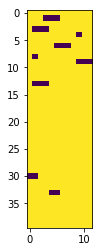

In [48]:
fig = plt.figure()
ims = []

case_num = 0
for i in range(frames.shape[0]):
    # 温度を画像化
    im = plt.imshow(frames[i, case_num, 2,:])
    ims.append(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=100)
plt.show()

In [52]:
frames[0,0,2,:]

array([[27.394, 26.959, 26.947, 26.954, 26.96 , 26.965, 26.969, 26.972,
        26.975, 26.976, 26.974, 26.97 ],
       [26.963, 26.955, 26.95 ,  0.   ,  0.   ,  0.   , 26.642, 26.616,
        26.61 , 26.603, 26.562, 26.46 ],
       [26.378, 26.319, 26.275, 26.253, 26.243, 26.244, 26.266, 26.292,
        26.334, 26.446, 26.476, 26.459],
       [26.463,  0.   ,  0.   ,  0.   , 27.692, 27.037, 26.984, 26.993,
        27.006, 27.017, 27.027, 27.036],
       [27.042, 27.045, 27.042, 27.032, 27.014, 26.988, 26.952, 26.909,
        26.808,  0.   , 26.659, 26.636],
       [26.617, 26.604, 26.572, 26.5  , 26.351, 26.226, 26.166, 26.132,
        26.125, 26.138, 26.171, 26.246],
       [26.379, 26.577, 26.542, 26.487, 26.468,  0.   ,  0.   ,  0.   ,
        27.966, 27.149, 27.048, 27.055],
       [27.076, 27.095, 27.113, 27.127, 27.138, 27.143, 27.139, 27.124,
        27.096, 27.056, 27.004, 26.948],
       [26.897,  0.   , 26.72 , 26.705, 26.717, 26.744, 26.759, 26.732,
        26.391, 26.275, 

In [35]:
frames.shape

(60, 10, 3, 40, 12)

In [19]:
Env_play[0].present_time

0

In [20]:
Env_play[1].present_time

300

In [21]:
Env_play[0].end

100000

In [29]:
reward_save

[[-0.8224467511787407,
  -1.3669591451288028,
  -1.9787978896864118,
  -2.898081630030883,
  -3.9042013128236186,
  -5.147901376022106,
  -6.670090659700792,
  -7.962933450206904,
  -8.761844023255382,
  -9.0],
 [-1.7181443888402392,
  -2.346494485765093,
  -2.84371373312227,
  -3.7142762804947167,
  -4.899839146745124,
  -6.233043903914987,
  -7.338112953933923,
  -8.1911592605691,
  -8.792674898959064,
  -9.0],
 [-2.6622878397848444,
  -3.3365533945117574,
  -3.6487608047307103,
  -4.524073690834636,
  -5.973676339266045,
  -6.970629680760715,
  -7.745303150380444,
  -8.287021837600864,
  -8.94433968987339,
  -8.97821062299118],
 [-3.561328109271589,
  -4.1269635184672415,
  -4.442378937077765,
  -5.275090596862893,
  -6.749203048589212,
  -7.449750096764675,
  -7.871564654033033,
  -8.866077799493334,
  -8.939975522143678,
  -8.907618986705215],
 [-4.371706075496633,
  -4.972565870042555,
  -5.197616775033402,
  -6.26303049247377,
  -7.256905287030988,
  -7.641178922739848,
  -8.767

### 後処理
##### まず、残ったCaseを見てく

In [ ]:
# CASEを作成
CASEs = [SolutionDirectory("./Case/case{}".format(i)) for i in range(NUM_PROCESSES)]
Envs_after = list(map(lambda x: AircondAfterCalculation(x), CASEs))


In [ ]:
first=0
last=3010
step=100

In [ ]:
# PMVファイルを作らす
[x.makePMVList(first, last, step) for x in Envs_after]

In [ ]:
# TとUとMRTの平均値を取得
T_list=[]
U_list=[]
MRT_list=[]
for env in Envs_after:
    T,U,MRT = env.getTUList(first, last, step)
    T_list.append(T)
    U_list.append(U)
    MRT_list.append(MRT)

In [ ]:
# PMVとPPDとを取得
PMV_list=[]
PPD_list=[]
for env in Envs_after:
    PMV,PPD = env.getPMVList(first, last, step)
    PMV_list.append(PMV)
    PPD_list.append(PPD)

In [ ]:
# ADPIとEUCを取得
ADPI_list=[]
EUC_list=[]
for env in Envs_after:
    ADPI = env.getADPIList(first, last, step)
    EUC = env.getEUCList(first, last, step)
    ADPI_list.append(ADPI)
    EUC_list.append(EUC)

In [ ]:
time_list = np.array([x for x in range(first, last, step)])/60

### プロット

In [ ]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [ ]:
from collections import OrderedDict
linestyles_ = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     
     ('loosely dashdotdotdotted', (0, (3,10,1,10,1,10,1,10))),
     ('dashdotdotdotted', (0, (3,5,1,5,1,5,1,5))),     
     ('densely dashdotdotdotted', (0, (3,1,1,1,1,1,1,1))),    
    ])

In [ ]:
linestyles = [linestyle for name, linestyle in linestyles_.items()]

In [ ]:
linestyles = linestyles*3

In [ ]:
# Tのプロット
for i in range(NUM_PROCESSES):
    plt.plot(time_list, T_list[i], label='case 1-{}'.format(i), \
             linestyle=linestyles[i])
#plt.plot(time_list, T_b, label='case 1-2',linestyle='dashed')
#plt.plot(time_list, T_d, label='case 1-3',linestyle='dashdot')
#plt.plot(time_list, T_f, label='case 1-4',linestyle='dotted')
plt.xlabel("Time[m]")
plt.ylabel("T[℃]")
plt.title('average T')
plt.xlim(0,50)
#plt.ylim(-0.5,2.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("T_123.png",dpi=150)

In [ ]:
# Tのプロット
for i in range(NUM_PROCESSES):
    plt.plot(time_list, PMV_list[i], label='case 1-{}'.format(i), \
             linestyle=linestyles[i])
#plt.plot(time_list, T_b, label='case 1-2',linestyle='dashed')
#plt.plot(time_list, T_d, label='case 1-3',linestyle='dashdot')
#plt.plot(time_list, T_f, label='case 1-4',linestyle='dotted')
plt.xlabel("Time[m]")
plt.ylabel("PMV")
plt.title('average PMV')
plt.xlim(0,50)
#plt.ylim(-0.5,2.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("T_123.png",dpi=150)

In [398]:
class Sample_list:
    """リストで全部処理しようとするver。未完成。"""
    def __init__(self, CASE):
        self.CASE = CASE
        # メッシュの情報を全て読み込む
        self.read_all()
        
        self.points = self.pointslist_to_array(self.points_)  # 各点の座標。順番に番号が0から振られている。
        self.faces = self.faceslist_to_array(self.faces_)  # 各面がどの点から構成されているか、pointsの番号と対応
        self.owner = self.strlist_to_array(self.owner_)  # 各面がどのセルに属しているか。
        self.neighbour = self.strlist_to_array(self.neighbour_)  # 各面がどのセルと隣り合っているか。

    def read_polyMesh(self,name):
        """constantのployMesh中のメッシュ情報のファイルを読み込む関数。
        一行ずつ読み込んで、ヘッダーと空白を消して、読み込むという強引なことをしているので、
        情報が縦にきじゅつされていないは想定していない。
        """
        with open (self.CASE.name + "/constant/polyMesh/{}".format(name),"r") as f:
            lines = f.readlines()  # 読み込み
            # 改行コードを取り除く
            meshinfo = []
            meshinfo_append = meshinfo.append
            for line in lines:
                line_ = line.rstrip('\n')
                # "" のような空の文字列を取り除いて、始まる数を揃える
                if len(line_)!=0:
                    meshinfo_append(line_)
            # header部分の'}'の部分を特定する
            for i,mesinf in enumerate(meshinfo):
                if mesinf=='}':
                    break
            meshinfo_num = meshinfo[i+2]  # i+2番目に最初の数の情報
            meshinfo_ = meshinfo[i+4:-2]  # i+4番目-2までが中身
        return meshinfo_num, meshinfo_

    def read_all(self):
        """constantのpolymeshの中の情報をクラス内のインスタンスに読み込む。
        self.faces_num等に個数、self.faces_等にリスト化された情報が読み込まれる。
        """
        # boundary_num, boundary = read_polyMesh("bouundary")
        polyMeshs = ["boundary", "cellZones", "faces", "neighbour", "owner", "points", "pointZones"]
        for poly in polyMeshs:
            # 例 : self.faces_num, self.faces_ = self.read_polyMesh(faces)
            exec("self."+poly+"_num, self."+poly+"_"+"=" + "self.read_polyMesh(poly)")
            
    def pointvector_split(self, str_):
        """
        '(0 0 0)'のようなベクトルをflattenして、floatにする。
        pointsのmap用
        """
        str_split = str_.strip("()").split(" ")
        float_split = [float(x) for x in str_split]
        return float_split
    
    def pointslist_to_array(self, meshinfo):
        """
        ['(0 0 0)','(0 0 1)']とかで構成されたリストをnumpyにする。
        points用。pointvector_splitを使用する。
        """
        return list(map(self.pointvector_split, meshinfo))
    
    def strlist_to_array(self,meshinfo):
        """
        ['(0 0 0)','(0 0 1)']とかで構成されたリストをnumpyにする。
        owner用
        """
        return list(map(int, meshinfo))
    
    def facevector_split(self,face):
        """
        '4(1 37 554 518)'のようなベクトルをsplitして、floatにする。
        4 1 37 554 518のようなarrayに
        neighbourのmap用。
        """
        face_ = face.split("(")  # 4と()部分を分ける
        face_num = face_[0]
        face_body = face_[1]
        face_split = face_body.strip("()").split(" ")
        float_split = [int(face_num)] + [int(x) for x in face_split]
        return float_split
    
    def faceslist_to_array(self,faces):
        """
        ['4(1 37 554 518)','4(36 553 554 37)']とかで構成されたリストをnumpyにする。
        neighbour用。
        """
        faces_ = list(map(self.facevector_split, faces))
        # Noneでnp.array化するver。
        #l = max(map(len,faces_))
        #faces_after = list(map(lambda x: x+[None]*(l-len(x)), faces_))
        return faces_
    
    def make_mesh_points(self, points='self', faces='self', owner='self', neighbour='self'):
        
        # セルのnumberと6つのpointsからなる座標を対応付ける。
        if points=='self':
            points = self.points
        if faces=='self':
            faces = self.faces
        if owner=='self':
            owner = self.owner
        if neighbour=='self':
            neighbour = self.neighbour
            
        # faceとpointsを対応付ける。
        # faceの情報をpointsに直す
        faces_points = []
        faces_points_append = faces_points.append
        len_faces = len(faces)  # facesの数
        n_faces = [x[0] for x in faces]  # 1faceの中でのpointsの数
        #n_face_max = n_faces.max()
        for i in range(len_faces):
            face_point = []
            face_point_append = face_point.append
            for j in range(n_faces[i]):
                coordinate = points[faces[i][j+1]]
                face_point_append(coordinate)
            faces_points_append(face_point)

        # セルとpointsを対応付ける
        n_cells = max(owner)+1
        cell_faces_points = [[] for i in range(n_cells)]

        # まず、各faceがどのセルに属しているかを算出し、該当するセルにpointsを追加する
        len_owner = len(owner)
        for i in range(len_owner):
            face_point = faces_points[i]
            cell_faces_points[owner[i]].append(face_point)

        # neighbourの情報から、各faceがどのセルに属するかを算出し、該当するセルにpointsを追加する
        len_neighbour = len(neighbour)
        for i in range(len_neighbour):
            # 面の向きをそろえるために、neighbourで追加するセルは、逆向きにする
            face_point = faces_points[i].copy()
            tmp = face_point[1].copy()
            face_point[1] = face_point[3]
            face_point[3] = tmp
            cell_faces_points[neighbour[i]].append(face_point)
            
        # Noneでnp.arrayにするver          
        l = 0
        for face in cell_faces_points:
            if len(face) >= l:
                l = len(face)

        dummy_face = [[[None, None, None]]*n_face_max]
        cell_faces_points_ = list(map(lambda x: x + dummy_face*(l-len(x)), cell_faces_points))
        cell_faces_points = np.array(cell_faces_points_)
            
        # -------------------ここから下はできてない--------------------------

        # セルのfacesから被りpointsをなくして、構成される点にする。
        cell_points = []
        cell_points_append = cell_points.append
        for cfp in cell_faces_points:
            points_flatten = cfp.reshape(-1,cfp.shape[-1])
            points_unique = pd.DataFrame(points_flatten).drop_duplicates().values
            cell_points_append(points_unique)
        cell_points = np.array(cell_points)

        # セルのポイントを中心にする
        cell_points_center = []
        cell_points_center_append = cell_points_center.append

        for cell in cell_points:
            cell_center = np.mean(cell, axis=0)
            cell_points_center_append(cell_center)
        cell_points_center = np.array(cell_points_center)
        
        # 定義域
        # pointsの定義域を算出する
        # [8.0, 2.4 , 0.1]など
        cell_points_flatten = cell_points.reshape(-1,3)
        min_cell_point = np.min(cell_points_flatten, axis=0)
        max_cell_point = np.max(cell_points_flatten, axis=0)
        domain = np.array([min_cell_point, max_cell_point])
        
        self.faces_points = faces_points
        self.cell_faces_points = cell_faces_points
        self.cell_points = cell_points
        self.cell_points_center = cell_points_center
        self.domain = domain
        
        return self.faces_points, self.cell_faces_points, self.cell_points, self.cell_points_center, self.domain


In [ ]:
## この環境の部分を変える

class Aircond:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=500,end=3000,xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5])
        self.action_DIRECTION = np.array([-1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([18+273.15,22+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得
        各U1, U2, Tがすべて一列で並んだ状態を返す'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir,celsius=True):
        '''observationを２次元で取得。
        障害物があるところは全て値を0で埋める。
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        # セルシウス℃に直す
        if celsius:
            T_value = self.Celsius_(T_value)
            T_value = T_value.astype(np.float64)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        """PMVとPPDを計算
        デフォルト値。TA,VA,TR,RHまでは入力を推奨
        TA = 20  #  温度[℃]
        VA = 0.3  # 流速[m/s]
        TR = 20  # MRT[℃]
        RH = 50  # 相対湿度[%]
        AL = 1  # 活動量[met]
        CLO = 1 # 着衣量[clo]
        
        """
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        #
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''np.arrayの配列をセルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed,RH=50,AL=1,CLO=1):
        '''PMVを一つのtime_stepで全点計算
        TU_Parsed : TとUのParsedParameterFileをリストにしたもの
        全ての点のPMVとPPVの値を返す
        time=0でも、すべてのセルの値を返す。'''
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius_(T)
            MRTc = self.Celsius_(MRT)
            pmv,ppd = self.calc_PMV(TA=Tc,VA=Us,TR=MRTc,RH=RH,AL=AL,CLO=CLO)
            PMV = np.tile(pmv, self.nCells)
            PPD = np.tile(ppd, self.nCells)
        else:   
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = list(self.Celsius_(T))
            MRTc = self.Celsius_(MRT)
            
            length = len(T)
            # ループを早くするため、外に出す。
            PMV = []
            PPD = []
            PMVappend = PMV.append
            PPDappend = PPD.append
            for i in range(length):
                pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=RH,AL=AL,CLO=CLO)
                PMVappend(pmv)
                PPDappend(ppd)
            PMV = np.array(PMV)
            PPD = np.array(PPD)
        return [PMV,PPD]
    
    def calc_PMV_error(self, TU_Parsed,RH=50,AL=1,CLO=1):
        """PMVの全点の2条誤差の合計を計算
        入力はcalc_PMV_allと同じ。返すものだけが違う。
        PMVは、0との2乗誤差、PPDは0との、根平均2乗誤差を返す。
        """
        PMV, PPD = self.calc_PMV_all(TU_Parsed, RH=RH,AL=AL,CLO=CLO)
        PMV_mae = ((PMV - 0)**2).mean()
        PPD_rmse = np.sqrt( ((PPD - 0)**2).mean())
        return PMV_mae, PPD_rmse
    
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
            
    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]
        
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        
        
    def reset(self):
        '''環境のリセット'''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム）
        T_initial = ParsedParameterFile(self.CASE.initialDir() + '/T')
        # random parameter from 26 to 35
        T_rand = np.random.randint(26+273,35+273)
        T_initial['internalField'].setUniform(T_rand)
        T_initial.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        return self.observation
    
    def step_old(self, action):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
    
    
    def step(self, action, reward='PMV'):
        '''ステップを進める
        報酬はPMV等から選択
        '''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
            # rewardと、observationは1ステップ前の値をそのまま使う。
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
            # 報酬の計算。make_observationでは、0を補完していれているため、用いない。
            T_new = ParsedParameterFile(self.CASE.latestDir() + '/T')
            U_new = ParsedParameterFile(self.CASE.latestDir() + '/U')
            TU_Parsed = [T_new,U_new]
            PMV_mae, PPD_rmse = self.calc_PMV_error(TU_Parsed, RH=50,AL=1,CLO=1)
            # 報酬は、ズレ分をマイナス、ちかづいたら、プラスにする。
            self.reward = -PMV_mae + 1
            
        
        return (self.observation, self.reward, done, runOK)
        

In [ ]:
# aircondを並列でたくさんつくるためのクラス

# ケースの作成
def makecase(NUM_PROCESSES,stride=500, end=3000, xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
    """並列でたくさんのケースをつくる"""
    os.system("./makecase {}".format(NUM_PROCESSES))
    Envs = []
    Envs_append = Envs.append
    for i in range(NUM_PROCESSES):
        CASE = SolutionDirectory("./Case/case{}".format(i))
        aircond = Aircond(CASE, stride=stride, end=end, xCells=xCells, insert_list=insert_list)
        Envs_append(aircond)
    return Envs

In [ ]:
# 定数の設定

#ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
NUM_SKIP_FRAME = 4 # skipするframe数です
NUM_STACK_FRAME = 1  # 状態として連続的に保持するframe数です
NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 2 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 5  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 0.99  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは125,000となる


In [ ]:
NUM_UPDATES = 10

In [ ]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 0.99


In [ ]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


In [ ]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化12*40→4*18
            init_(nn.Conv2d(3, 32, kernel_size=5,stride=2)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化4*18→3*17
            init_(nn.Conv2d(32, 64, kernel_size=2, stride=1)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=2, stride=1)),  # 画像サイズの変化3*17→2*16
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 2 * 16, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        #input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        input = x  # 正規化はしない
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy


In [ ]:
def resets(Envs):
    """resets all"""
    obs = []
    obs_append = obs.append
    for i in range(len(Envs)):
        obs_ = Envs[i].reset()
        obs_append(obs_)
    obs = np.array(obs)
    return obs

In [ ]:
def steps(Envs, action):
    """すべての環境で同じだけステップを進める
    obsはnumpy, done, runOKはリスト
    """
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(len(Envs)):
        obs_, reward_, done_, runOK_ = Envs[i].step(action[i])
        obs_append(obs_)
        reward_append(reward_)
        done_append(done_)
        runOK_append(runOK_)
    obs = np.array(obs)
    return obs, reward, done, runOK
    

In [ ]:
def make_random_actions(Envs, max_execution=3):
    """適当にステップを進めて、環境をバラバラにする。
    環境のリスト
    max_execution : 進める最大のステップ。0~ステップ分進めることになる。
    random_actionは複素数で返す。0+1Jは補完したもの。
    """
    # 0~max_executions
    # 複素数にして、1jは補完したものとする。
    action_shape = Envs[0].action_space.shape[0]
    random_actions = []
    for i in range(len(Envs)):
        i_th_action = []
        for j in range(random.randint(0,max_execution)):
            i_th_action.append(random.randint(0, action_shape-1))
        random_actions.append(i_th_action)
        
    max_len = max(map(len, random_actions))
    random_actions = np.array(list(map(lambda x:x + [1j]*(max_len-len(x)), random_actions)))
    random_actions = random_actions.astype(np.complex128)
    return random_actions

In [ ]:
def random_steps(Envs, random_actions, step_reset=True):
    """random_actions分それぞれステップを進める。
    Envs : 環境のリスト
    random_actions, len(Envs)行,進めるステップ分で構成された、random_step。
    step_reset : Envs内のpresent_timeをリセットするかどうか。
    """
    # random_step分stepを進めて、とりあえず、リストとして保存。
    obs_list = []
    reward_list = []
    done_list = []
    runOK_list = []
    obs_list_append = obs_list.append
    reward_list_append = reward_list.append
    done_list_append = done_list.append
    runOK_list_append = runOK_list.append
    # random_actions.shape[0] == len(Envs)だが、やりたくない環境がある場合
    # やらないために、len(Envs)は使わない
    for i in range(random_actions.shape[0]):
        obs_progress = []
        reward_progress = []
        done_progress = []
        runOK_progress = []
        obs_progress_append = obs_progress.append
        reward_progress_append = reward_progress.append
        done_progress_append = done_progress.append
        runOK_progress_append = runOK_progress.append
        
        for j in range(random_actions.shape[1]):
            if random_actions[i,j].imag==0:  # 補完しただけのものには1jが入ってる
                obs_, done_, reward_, runOK_ = Envs[i].step(int(random_actions[i,j].real))
                obs_progress_append(obs_)
                reward_progress_append(reward_)
            else:
                done_, runOK_ = False, True
            done_progress_append(done_)
            runOK_progress_append(runOK_)
            
        obs_list_append(obs_progress)
        reward_list_append(reward_progress)
        done_list_append(done_progress)
        runOK_list_append(runOK_progress)
    
    # 進めた結果をまとめる。
    # obs → 最後のステップのobservation or 進めない場合、そのままのobservation
    # reward → 最後のステップのreward or 進めない場合、そのままのreward
    # done → 一個でもdoneがあれば、done=Trueとする。
    # runOK → 一個でも、Falseがあれば、Falseとする。
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(random_actions.shape[0]):
        if obs_list[i]==[]:
            obs_ = Envs[i].observation
        else:
            obs_ = obs_list[i][-1]
        obs_append(obs_)
        
        if reward_list[i]==[]:
            reward_ = Envs[i].reward
        else:
            reward_ = reward_list[i][-1]
        reward_append(reward_)
        
        if any(done_list[i]):
            done_ = True
        else:
            done_ = False
        done_append(done_)
        
        if all(runOK_list[i]):
            runOK_ = True
        else:
            runOK_ = False
        runOK_append(runOK_)
    obs = np.array(obs)
    
    if step_reset:
        for i in range(random_actions.shape[0]):
            Envs[i].present_time=0
            
    return obs, reward, done, runOK

In [ ]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done,runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 12500 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


In [ ]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)


In [ ]:

# 実行ループ
#for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    #for step in range(NUM_ADVANCED_STEP):


j=0
step=0

# 行動を求める
with torch.no_grad():
    action = actor_critic.act(rollouts.observations[step])

cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

# 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
obs, reward, done,runOK = steps(Envs, cpu_actions)

# 報酬をtensorに変換し、試行の総報酬に足す
# sizeが(16,)になっているのを(16, 1)に変換
reward = np.expand_dims(np.stack(reward), 1)
reward = torch.from_numpy(reward).float()
episode_rewards += reward

# 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
masks = torch.FloatTensor(
    [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
# 最後の試行の総報酬を更新する
final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
# 継続中は0を足す、done時にはepisode_rewardsを足す
final_rewards += (1 - masks) * episode_rewards


# 試行の総報酬を更新する
episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

# masksをGPUへ
masks = masks.to(device)

# 現在の状態をdone時には全部0にする
# maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
current_obs *= masks.unsqueeze(2).unsqueeze(2)

# frameをstackする
# torch.Size([16, 1, 40, 12])
obs = torch.from_numpy(obs).float()
current_obs = obs.to(device)  # 最新のobsを格納

# メモリオブジェクトに今stepのtransitionを挿入
rollouts.insert(current_obs, action.data, reward, masks)

# ------------------

# advancedのfor loop終了

# advancedした最終stepの状態から予想する状態価値を計算
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.observations[-1]).detach()
    
    
# 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
rollouts.compute_returns(next_value)


# ネットワークとrolloutの更新
global_brain.update(rollouts)
rollouts.after_update()

# ログ：途中経過の出力
if j % 100 == 0:
    print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
          format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                 final_rewards.mean(),
                 final_rewards.median(),
                 final_rewards.min(),
                 final_rewards.max()))

# 結合パラメータの保存
if j % 12500 == 0:
    torch.save(global_brain.actor_critic.state_dict(),
               'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

In [323]:

# faceとpointsを対応付ける。
# faceの情報をpointsに直す
faces_points = []
faces_points_append = faces_points.append
len_faces = len(faces)  # facesの数
n_face = np.array(faces)[:,0]  # 1faceの中でのpointsの数
n_face_max = n_face.max()
for i in range(len_faces):
    face_point = []
    face_point_append = face_point.append
    for j in range(n_face_max):
        if faces[i][j+1] is None:
            coordinate = [None, None, None]
        else:
            coordinate = points[faces[i][j+1]]
        face_point_append(coordinate)
    faces_points_append(face_point)
#faces_points = np.array(faces_points)

# セルとpointsを対応付ける
n_cells = max(owner)+1
cell_faces_points = [[] for i in range(n_cells)]

# まず、各faceがどのセルに属しているかを算出し、該当するセルにpointsを追加する
len_owner = len(owner)
for i in range(len_owner):
    face_point = faces_points[i]
    cell_faces_points[owner[i]].append(face_point)

# neighbourの情報から、各faceがどのセルに属するかを算出し、該当するセルにpointsを追加する
len_neighbour = len(neighbour)
for i in range(len_neighbour):
    # 面の向きをそろえるために、neighbourで追加するセルは、逆向きにする
    face_point = faces_points[i].copy()
    tmp = face_point[1].copy()
    face_point[1] = face_point[3]
    face_point[3] = tmp
    cell_faces_points[neighbour[i]].append(face_point)

#cell_faces_points = np.array(cell_faces_points)



In [356]:
l = 0
for face in cell_faces_points:
    if len(face) >= l:
        l = len(face)
        
dummy_face = [[[None, None, None]]*n_face_max]
cell_faces_points_ = list(map(lambda x: x + dummy_face*(l-len(x)), cell_faces_points))

In [367]:
cell_faces_points = np.array(cell_faces_points_)

In [375]:
len_cell_max=0
for cell in cell_points:
    if len_cell_max <= cell.shape[0]:
        len_cell_max = cell.shape[0]
len_cell_max

11

In [376]:
cell_points

[array([[0.2, 0.0, 0.0],
        [0.2, 0.2, 0.0],
        [0.2, 0.2, 0.1],
        [0.2, 0.0, 0.1],
        [None, None, None],
        [0.0, 0.2, 0.0],
        [0.0, 0.2, 0.1],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.1]], dtype=object), array([[0.4, 0.0, 0.0],
        [0.4, 0.2, 0.0],
        [0.4, 0.2, 0.1],
        [0.4, 0.0, 0.1],
        [None, None, None],
        [0.2, 0.2, 0.0],
        [0.2, 0.2, 0.1],
        [0.2, 0.0, 0.0],
        [0.2, 0.0, 0.1]], dtype=object), array([[0.6, 0.0, 0.0],
        [0.6, 0.2, 0.0],
        [0.6, 0.2, 0.1],
        [0.6, 0.0, 0.1],
        [None, None, None],
        [0.4, 0.2, 0.0],
        [0.4, 0.2, 0.1],
        [0.4, 0.0, 0.0],
        [0.4, 0.0, 0.1]], dtype=object), array([[0.8, 0.0, 0.0],
        [0.8, 0.2, 0.0],
        [0.8, 0.2, 0.1],
        [0.8, 0.0, 0.1],
        [None, None, None],
        [0.6, 0.2, 0.0],
        [0.6, 0.2, 0.1],
        [0.6, 0.0, 0.0],
        [0.6, 0.0, 0.1]], dtype=object), array([[1.0, 0.0, 0.0],
   

In [371]:
# セルのfacesから被りpointsをなくして、構成される点にする。

cell_points = []
cell_points_append = cell_points.append
for cfp in cell_faces_points:
    points_flatten = cfp.reshape(-1,cfp.shape[-1])
    points_unique = pd.DataFrame(points_flatten).drop_duplicates().values
    cell_points_append(points_unique)
cell_points = cell_points

# セルのポイントを中心にする
cell_points_center = []
cell_points_center_append = cell_points_center.append

for cell in cell_points:
    cell_center = np.mean(cell, axis=0)
    cell_points_center_append(cell_center)
cell_points_center = np.array(cell_points_center)

# 定義域
# pointsの定義域を算出する
# [8.0, 2.4 , 0.1]など
cell_points_flatten = cell_points.reshape(-1,3)
min_cell_point = np.min(cell_points_flatten, axis=0)
max_cell_point = np.max(cell_points_flatten, axis=0)
domain = np.array([min_cell_point, max_cell_point])

self.faces_points = faces_points
self.cell_faces_points = cell_faces_points
self.cell_points = cell_points
self.cell_points_center = cell_points_center
self.domain = domain

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [ ]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done,runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 12500 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


In [ ]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)


In [ ]:

# 実行ループ
#for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    #for step in range(NUM_ADVANCED_STEP):


j=0
step=0

# 行動を求める
with torch.no_grad():
    action = actor_critic.act(rollouts.observations[step])

cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

# 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
obs, reward, done,runOK = steps(Envs, cpu_actions)

# 報酬をtensorに変換し、試行の総報酬に足す
# sizeが(16,)になっているのを(16, 1)に変換
reward = np.expand_dims(np.stack(reward), 1)
reward = torch.from_numpy(reward).float()
episode_rewards += reward

# 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
masks = torch.FloatTensor(
    [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
# 最後の試行の総報酬を更新する
final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
# 継続中は0を足す、done時にはepisode_rewardsを足す
final_rewards += (1 - masks) * episode_rewards


# 試行の総報酬を更新する
episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

# masksをGPUへ
masks = masks.to(device)

# 現在の状態をdone時には全部0にする
# maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
current_obs *= masks.unsqueeze(2).unsqueeze(2)

# frameをstackする
# torch.Size([16, 1, 40, 12])
obs = torch.from_numpy(obs).float()
current_obs = obs.to(device)  # 最新のobsを格納

# メモリオブジェクトに今stepのtransitionを挿入
rollouts.insert(current_obs, action.data, reward, masks)

# ------------------

# advancedのfor loop終了

# advancedした最終stepの状態から予想する状態価値を計算
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.observations[-1]).detach()
    
    
# 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
rollouts.compute_returns(next_value)


# ネットワークとrolloutの更新
global_brain.update(rollouts)
rollouts.after_update()

# ログ：途中経過の出力
if j % 100 == 0:
    print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
          format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                 final_rewards.mean(),
                 final_rewards.median(),
                 final_rewards.min(),
                 final_rewards.max()))

# 結合パラメータの保存
if j % 12500 == 0:
    torch.save(global_brain.actor_critic.state_dict(),
               'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')